### Vision-Transformer (ViT)

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.utils.layer_utils import count_params
import tensorflow_addons as tfa 
import matplotlib.pyplot as plt
from contextlib import redirect_stdout

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
num_classes = 100  # Classes in the "Cifar100" dataset
input_shape = (32, 32, 3)  # height, width, color channels

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [3]:
# model hyper-parameter configuration
learning_rate = 0.00075
weight_decay = 0.0001
batch_size = 128
num_epochs = 150

image_size = 100   # size used for the images
patch_size = 10    # patch size
num_patches = (image_size // patch_size) ** 2

projection_dim = 64
num_heads = 8
transformer_units = [ # number of cells in the Dense layers of the Transformer block
    projection_dim * 2,
    projection_dim,
]

transformer_layers = 16  # number of Transformer blocks

mlp_head_units = [1024, 512]  # dimensions of the Dense layers of the final classifier

In [4]:
data_augmentation = keras.Sequential(
    [
        tf.keras.layers.Normalization(),
        tf.keras.layers.Resizing(image_size, image_size),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(factor=0.05),
        tf.keras.layers.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1)),
    ],
    name="data_augmentation",
)
data_augmentation.layers[0].adapt(x_train)

In [5]:
# Definition of a FeedForward Network
def mlp(x, hidden_layers, dropout_rate):
    for cells in hidden_layers:
        x = tf.keras.layers.Dense(cells, activation=tf.keras.activations.swish)(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    return x

In [6]:
class Patches(tf.keras.layers.Layer):
    # Layer for patch creation
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1], # rates are used to downsample the output, in this case, we do not downsample
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])  # -1 allows adapting the missing dimension based 
                                                                     # on the present elements and other declared dimensions
        return patches

Dimensione immagine: 100 X 100
Dimensione patch: 10 X 10
Patches per immagine: 100
Elementi per patch: 300


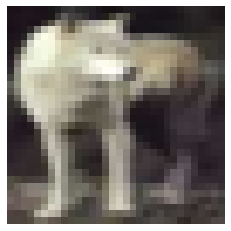

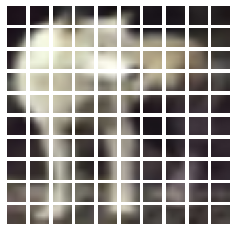

In [7]:
# Visualization of an example of patch creation

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Dimensione immagine: {image_size} X {image_size}")
print(f"Dimensione patch: {patch_size} X {patch_size}")
print(f"Patches per immagine: {patches.shape[1]}")
print(f"Elementi per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [8]:
# Patch Encoding Layer
# will linearly transform the patches by projecting them into a
# vector of dimension projection_dim.
# Additionally, it adds a learnable position
# embedding to the projected vector.
class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = tf.keras.layers.Dense(units=projection_dim)
        self.position_embedding = tf.keras.layers.Embedding(
            input_dim=num_patches, 
            output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

### Building the ViT Model

The **ViT** or **Vision-Transformer** was introduced in 2021 in the paper ["AN IMAGE IS WORTH 16X16 WORDS:
TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE"](https://arxiv.org/pdf/2010.11929v2.pdf).     

It consists of multiple Transformer blocks, which utilize the typical MultiHeadAttention layer (multiple self-attention mechanism) applied to a sequence of patches from the original image, to obtain a sequence of "elements" for analysis by the Transformer architecture.  
    
The Transformer blocks produce a tensor **[batch_size, num_patches, projection_dim]**,
which is then processed through a softmax classifier to produce the final output probabilities for each analyzed class.   
        
    
![](img/vision_transformer.png)    
    
In the [repository GitHub di Google Research](https://github.com/google-research) [some pre-trained ViT models](https://github.com/google-research/vision_transformer#available-vit-models) are available.    
    
Currently, they are widely used in image recognition and segmentation tasks, as well as in action recognition in videos. 
    
In ViTs, images are represented as sequences, allowing the model to learn the image structure from individual components. Input images are treated as a sequence of patches where each patch is flattened into a single vector by concatenating the channels of all pixels in a patch and then linearly projecting it to the desired input size.   
   


## Layer Normalization vs Batch Normalization    
<img src='img/batch_vs_layer_normalization.png'/>

In [9]:
def create_vit_classifier():
    inputs = tf.keras.layers.Input(shape=input_shape)

    augmented = data_augmentation(inputs)

    patches = Patches(patch_size)(augmented)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Creating the different layers necessary for implementing the Transformer blocks
    for _ in range(transformer_layers):
        x1 = tf.keras.layers.LayerNormalization(epsilon=1e-12)(encoded_patches)
        attention_output = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1, x1)
        x2 = tfa.tf.keras.layers.StochasticDepth()([encoded_patches, attention_output])
        x3 = tf.keras.layers.LayerNormalization(epsilon=1e-12)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = tfa.tf.keras.layers.StochasticDepth()([x2, x3])

    representation = tf.keras.layers.LayerNormalization(epsilon=1e-12)(encoded_patches)
    representation = tf.keras.layers.Flatten()(representation)
    representation = tf.keras.layers.Dropout(0.5)(representation)

    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)

    logits = tf.keras.layers.Dense(num_classes)(features)

    model = keras.Model(inputs=inputs, outputs=logits)
    return model

Model compiled.
____________________________
Total params: 9,548,587
Trainable params: 9,548,580
Non-trainable params: 7
____________________________
Epoch 1/150
391/391 [==============================] - 136s 311ms/step - loss: 4.4697 - accuracy: 0.0330 - top-5-accuracy: 0.1312 - val_loss: 4.1483 - val_accuracy: 0.0715 - val_top-5-accuracy: 0.2584
Epoch 2/150
391/391 [==============================] - 128s 326ms/step - loss: 4.0810 - accuracy: 0.0645 - top-5-accuracy: 0.2348 - val_loss: 3.7170 - val_accuracy: 0.1277 - val_top-5-accuracy: 0.3557
Epoch 3/150
391/391 [==============================] - 130s 332ms/step - loss: 3.7664 - accuracy: 0.1071 - top-5-accuracy: 0.3350 - val_loss: 3.4136 - val_accuracy: 0.1849 - val_top-5-accuracy: 0.4610
Epoch 4/150
391/391 [==============================] - 131s 334ms/step - loss: 3.4752 - accuracy: 0.1593 - top-5-accuracy: 0.4271 - val_loss: 3.2255 - val_accuracy: 0.2181 - val_top-5-accuracy: 0.5035
Epoch 5/150
391/391 [=========================

Epoch 41/150
391/391 [==============================] - 131s 335ms/step - loss: 1.8670 - accuracy: 0.4910 - top-5-accuracy: 0.7993 - val_loss: 1.8849 - val_accuracy: 0.4961 - val_top-5-accuracy: 0.7889
Epoch 42/150
391/391 [==============================] - 130s 333ms/step - loss: 1.8532 - accuracy: 0.4928 - top-5-accuracy: 0.8034 - val_loss: 1.8772 - val_accuracy: 0.4943 - val_top-5-accuracy: 0.7917
Epoch 43/150
391/391 [==============================] - 130s 333ms/step - loss: 1.8366 - accuracy: 0.4957 - top-5-accuracy: 0.8067 - val_loss: 1.8985 - val_accuracy: 0.4929 - val_top-5-accuracy: 0.7864
Epoch 44/150
391/391 [==============================] - 130s 333ms/step - loss: 1.8245 - accuracy: 0.4975 - top-5-accuracy: 0.8089 - val_loss: 1.8801 - val_accuracy: 0.4928 - val_top-5-accuracy: 0.7925
Epoch 45/150
391/391 [==============================] - 130s 333ms/step - loss: 1.8199 - accuracy: 0.5006 - top-5-accuracy: 0.8102 - val_loss: 1.8771 - val_accuracy: 0.4959 - val_top-5-accurac

391/391 [==============================] - 132s 336ms/step - loss: 1.4008 - accuracy: 0.5987 - top-5-accuracy: 0.8800 - val_loss: 1.7197 - val_accuracy: 0.5394 - val_top-5-accuracy: 0.8154
Epoch 122/150
391/391 [==============================] - 130s 332ms/step - loss: 1.3985 - accuracy: 0.6021 - top-5-accuracy: 0.8805 - val_loss: 1.6771 - val_accuracy: 0.5530 - val_top-5-accuracy: 0.8274
Epoch 123/150
391/391 [==============================] - 129s 331ms/step - loss: 1.3928 - accuracy: 0.6013 - top-5-accuracy: 0.8797 - val_loss: 1.6846 - val_accuracy: 0.5432 - val_top-5-accuracy: 0.8271
Epoch 124/150
391/391 [==============================] - 130s 333ms/step - loss: 1.3978 - accuracy: 0.6025 - top-5-accuracy: 0.8806 - val_loss: 1.7168 - val_accuracy: 0.5411 - val_top-5-accuracy: 0.8211
Epoch 125/150
391/391 [==============================] - 130s 333ms/step - loss: 1.3917 - accuracy: 0.6025 - top-5-accuracy: 0.8815 - val_loss: 1.6940 - val_accuracy: 0.5495 - val_top-5-accuracy: 0.8215

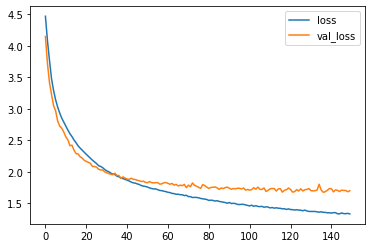

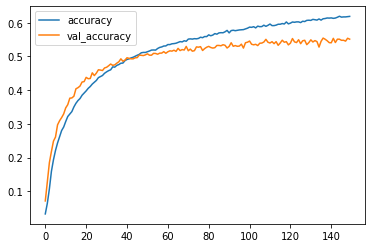

___________________________________________________________________________
Test accuracy: 55.44%
Test top 5 accuracy: 82.73%


In [10]:
def run_experiment(model):
    # Training and evaluation of the model
    optimizer = tfa.optimizers.AdamW(  # Adam with "weight decay"
        learning_rate=learning_rate,   # calculate weight updates like Adam
        weight_decay=weight_decay,     # but decrease the contribution of the update
        epsilon=1e-12                  # based on how much the weights vary
    )                                  # loss = loss + weight_decay * euclidean_norm(weights)
                                       # in TFA AdamW computes weight decay by considering the weights to be updated as:
                                       # weights = weights * (1 - (learning_rate * weight_decay))
                                       # functioning as a form of regularization of the weights themselves
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    with open('model_summary.txt', 'w') as f:
        with redirect_stdout(f):
            model.summary()
    
    trainable_count = count_params(model.trainable_weights)
    non_trainable_count = count_params(model.non_trainable_weights)
    print('Model compiled.\n____________________________')
    print('Total params: {:,}'.format(trainable_count + non_trainable_count))
    print('Trainable params: {:,}'.format(trainable_count))
    print('Non-trainable params: {:,}'.format(non_trainable_count))
    print('____________________________')
    
    keras.utils.plot_model(model, to_file='model_diagram.png', show_shapes=True, expand_nested=True)

    checkpoint_filepath = "./tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(x_test, y_test),
        callbacks=[checkpoint_callback],
    )
    
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.show()
    
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.legend()
    plt.show()
    
    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test, verbose=0)
    print('___________________________________________________________________________')
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()

# Training
# history = run_experiment(vit_classifier)

# Retrieving trained model
vit_classifier.load_weights('.....')

# Using the trained model on the 42nd test example
vit_classifier.predict(x_test[42])

Currently, the architecture that offers the best performance on the top-5 accuracy of the Cifar100 dataset is **SAM: Sharpness-Aware Minimization for Efficiently Improving Generalization** ([repository](https://github.com/google-research/sam) - [paper](https://arxiv.org/abs/2010.01412)),
presented by Google Research in 2020, followed by a Transformer-based implementation called 
**ViT-H/14**, also presented in 2020 ([paper](https://arxiv.org/pdf/2010.11929v2.pdf)).    
    